In [1]:
import tensorflow as tf
import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import MinMaxScaler, StandardScaler

2024-07-24 16:55:50.559946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 16:55:50.627868: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 16:55:50.644124: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-24 16:55:50.764035: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 16:55:51.896666: W tensorflow/compiler/tf2

In [2]:
class TimeSeriesDataset:
    def __init__(self, root_dir, feature_names=[]):
        self.data = self.load_data(root_dir, feature_names)

    def load_data(self, root_dir, feature_names):
        data = []

        for individual_dir in sorted(os.listdir(root_dir)):
            individual_path = os.path.join(root_dir, individual_dir)
            for class_dir in sorted(os.listdir(individual_path)):
                class_path = os.path.join(individual_path, class_dir)
                if os.path.isdir(class_path):
                    for file in glob.glob(os.path.join(class_path, "*.csv")):
                        df = pd.read_csv(file, usecols=feature_names)
                        class_name = os.path.splitext(os.path.basename(file))[0]
                        df["class"] = class_name
                        data.append(df)


        # Concatenate all data frames into a single data frame
        data = pd.concat(data, ignore_index=True)
        
        return data

In [3]:
root_dir = "glove_data"
feature_names = [
    "flex_1", "flex_2", "flex_3", "flex_4", "flex_5",
    "GYRx", "GYRy", "GYRz",
    "ACCx", "ACCy", "ACCz"
]

dataset = TimeSeriesDataset(root_dir, feature_names).data
# dataset = dataset.sort_values(by=["class"])

# filter_classes = ["deaf", "fine", "good", "goodbye", "hello"]
# dataset = dataset[dataset["class"].isin(filter_classes)]

x_train, y_train = dataset.iloc[:, :-1].values, dataset.iloc[:, -1].values

# x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))


timesteps = 150
n_features = 11
num_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)


x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)



In [4]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [5]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return Model(inputs, outputs)

In [6]:
# input_shape = x_train.shape[1:]


# model = build_model(
#     input_shape,
#     head_size=256,
#     num_heads=4,
#     ff_dim=4,
#     num_transformer_blocks=4,
#     mlp_units=[128],
#     mlp_dropout=0.4,
#     dropout=0.25,
# )

# model.compile(
#     loss="sparse_categorical_crossentropy",
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#     metrics=["sparse_categorical_accuracy"],
# )
# model.summary()

# callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

# model.fit(
#     x_train,
#     y_train,
#     epochs=1,
#     batch_size=64,
#     validation_split=0.2,
#     callbacks=callbacks,
# )

In [7]:
import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

dict_classifiers = {
  "Logistic Regression": LogisticRegression(max_iter=1000,solver='saga'),
  "Nearest Neighbors": KNeighborsClassifier(),
  "RBF SVM": SVC(C=10000,gamma=0.1),
  "Linear SVM": SVC(kernel='linear'),
  "Gradient Boosting Classifier": GradientBoostingClassifier(n_estimators=100),
  "Decision Tree": tree.DecisionTreeClassifier(),
  "Random Forest": RandomForestClassifier(n_estimators=100),
  "Neural Net": MLPClassifier(alpha = 1),
  "Naive Bayes": GaussianNB(),
  "AdaBoost": AdaBoostClassifier(),
  "QDA": QuadraticDiscriminantAnalysis(),
  "Gaussian Process": GaussianProcessClassifier()
}

dict_normalizers = {
  'No Normalizer': None,
  'StandardScaler': StandardScaler(),
  'MinMaxScaler': MinMaxScaler(),
  'MaxAbsScaler': MaxAbsScaler(),
  'RobustScaler': RobustScaler(),
  'QuantileTransformer-Normal': QuantileTransformer(output_distribution='normal'),
  'QuantileTransformer-Uniform': QuantileTransformer(output_distribution='uniform'),
  'PowerTransformer-Yeo-Johnson': PowerTransformer(method='yeo-johnson'),
  'Normalizer': Normalizer()
}


# def batch_classify(X_train, Y_train, X_test, Y_test, verbose = True):
#   """
#   This method, takes as input the X, Y matrices of the Train and Test set.
#   And fits them on all of the Classifiers specified in the dict_classifier.
#   The trained models, and accuracies are saved in a dictionary. The reason to use a dictionary
#   is because it is very easy to save the whole dictionary with the pickle module.

#   Usually, the SVM, Random Forest and Gradient Boosting Classifier take quiet some time to train.
#   So it is best to train them on a smaller dataset first and
#   decide whether you want to comment them out or not based on the test accuracy score.
#   """

#   dict_models = []
#   for classifier_name, classifier in list(dict_classifiers.items()):
#     for normalizer_name, normalizer in list(dict_normalizers.items()):
#       t_start = time.time()
#       pipe = Pipeline([('nomalizer', normalizer), ('clf', classifier)])
#       pipe.fit(X_train, Y_train)
#       t_end = time.time()

#       t_diff = t_end - t_start
#       train_score = pipe.score(X_train, Y_train)
#       test_score = pipe.score(X_test, Y_test)

#       dict_models.append([classifier_name, normalizer_name, train_score,
#                           test_score, t_diff])

#       if verbose:
#         print("trained {c} in {f:.2f} s".format(c=classifier_name + '__' + normalizer_name, f=t_diff))
#   return dict_models


# def display_dict_models(dict_models, sort_by="Test_Score"):
#   df = pd.DataFrame(dict_models, columns=["Classifier", "Normalizer", 
#                                           "Train_Score", "Test_Score", 
#                                           "Train_Time"])
  
#   df = df.sort_values(by=sort_by, ascending=False)
#   display(df)

In [8]:
classifier = "Random Forest" #@param ["Logistic Regression", "Nearest Neighbors", "RBF SVM", "Linear SVM", "Gradient Boosting Classifier", "Decision Tree", "Random Forest", "Neural Net", "Naive Bayes", "AdaBoost", "QDA", "Gaussian Process"]
clf = dict_classifiers[classifier]


clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)

print("Test Accuracy: %0.2f" %(accuracy_score(y_test,y_pred)))
if len(set(y_test)) > len(set(y_pred)):
  print("The model did not predict the following classes at all...")
  print(label_encoder.inverse_transform(list(set(y_test.astype(int)) - set(y_pred.astype(int)))))

print("\n\n")



KeyboardInterrupt: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7506
           1       1.00      1.00      1.00      7651
           2       0.98      0.98      0.98      7436
           3       1.00      0.99      1.00      7654
           4       1.00      1.00      1.00      7458
           5       0.99      0.99      0.99      7545
           6       0.99      0.99      0.99      7452
           7       1.00      1.00      1.00      7552
           8       0.99      1.00      0.99      7434
           9       1.00      1.00      1.00      7565
          10       0.98      0.98      0.98      7405
          11       0.99      0.99      0.99      7423
          12       1.00      1.00      1.00      7406
          13       0.99      0.99      0.99      7494
          14       1.00      0.99      1.00      7498
          15       1.00      1.00      1.00      7515
          16       1.00      1.00      1.00      7620
          17       1.00    

TypeError: too many positional arguments

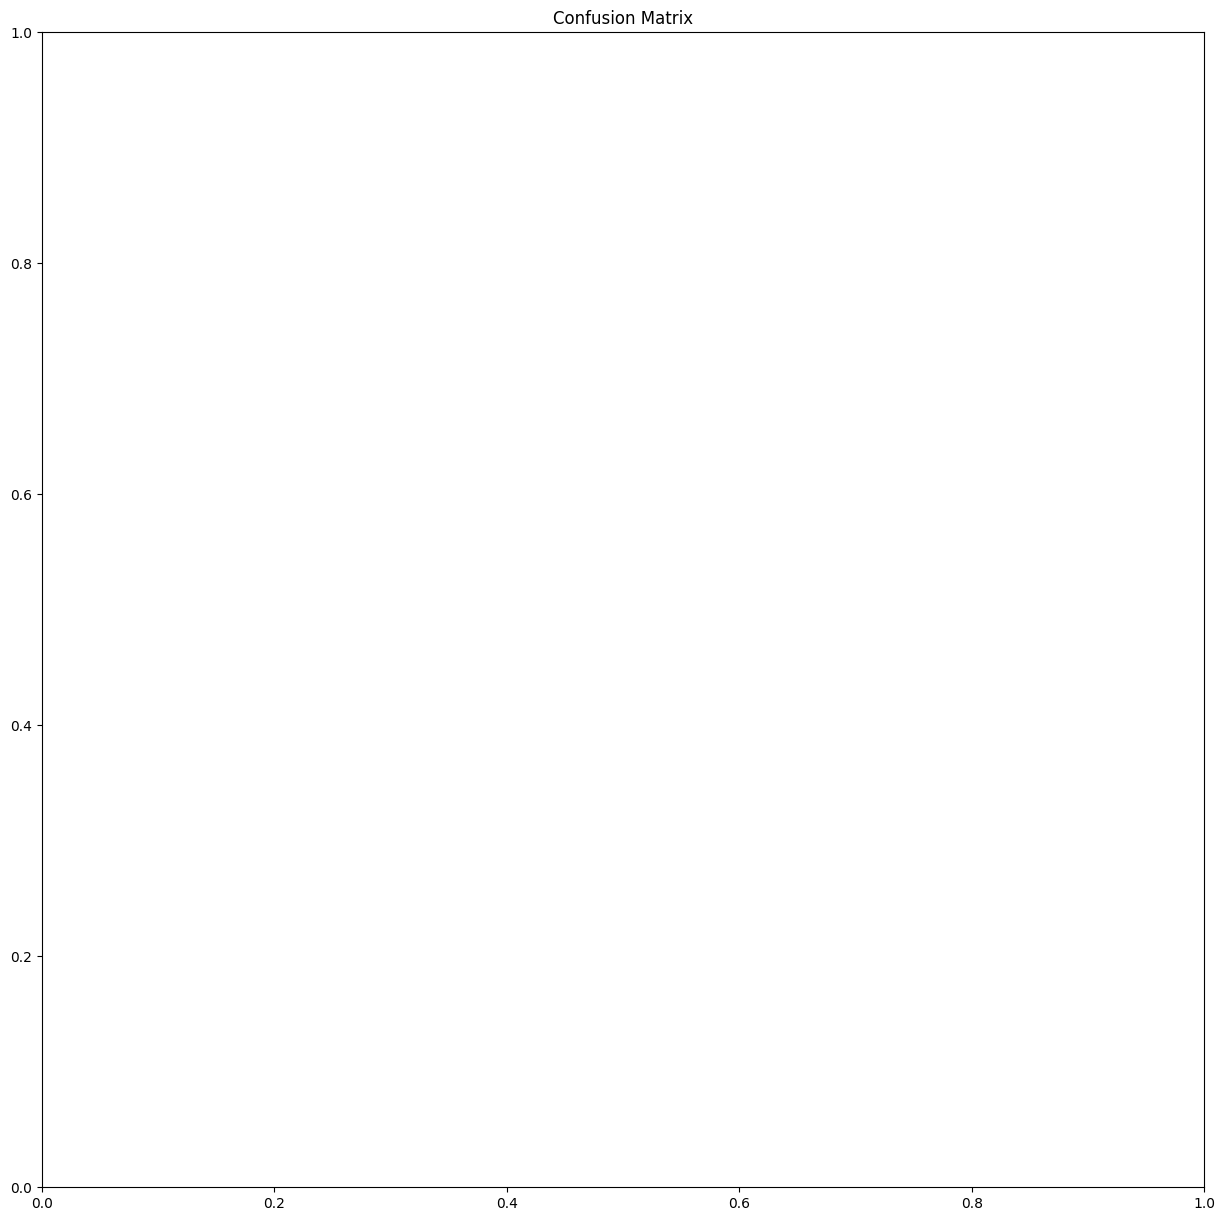

In [ ]:
show_classification_report = True #@param {type:"boolean"}
if show_classification_report:
  print(classification_report(y_test, y_pred))


show_confusion_matrix = False #@param {type:"boolean"}
if show_confusion_matrix:
  fig, ax = plt.subplots(figsize=(15, 15))
  title = "Confusion Matrix"
  ax.set_title(title)
  ax.set_facecolor('xkcd:white')

  # Plot Confusion Matrix
  confusion_matrix(clf, x_test, y_test, ax=ax, display_labels=list(label_encoder.classes_))
  # plot_confusion_matrix(clf, X_test, y_test, ax=ax, display_labels=list(label_encoder.classes_),
  #                             cmap=plt.cm.Blues,
  #                             normalize=None)

  plt.xticks(rotation=90)
  plt.show()

In [ ]:
# dict_models = batch_classify(x_train, y_train, x_test, y_test)
# display_dict_models(dict_models)